In [9]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np

# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

In [10]:
# loading the lattice from csv
lattice_path = os.path.relpath('../Data/dynamic output/voxelized_envelope.csv')
avail_lattice = tg.lattice_from_csv(lattice_path)
init_avail_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)

In [11]:
# creating neighborhood definition
stencil = tg.create_stencil("von_neumann", 1, 1)

In [12]:
insider = []
for i in avail_lattice.find_neighbours(stencil):
    inside = True
    for n in i:
        neigh_3d_id = np.unravel_index(n, init_avail_lattice.shape)
        if not avail_lattice[neigh_3d_id]:
            inside = False
    if inside:
        insider.append(np.unravel_index(i[0], init_avail_lattice.shape))

facade = avail_lattice
for i in insider:
    facade[i[0],i[1],:] = False

In [13]:
# initiating the plotter
p = pv.Plotter()

# fast visualization of the lattice
init_avail_lattice.fast_vis(p, color="66ccff")
facade.fast_vis(p)

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(285.05138968497397, 208.55138968497394, 271.55138968497397),
 (31.5, -45.0, 18.0),
 (0.0, 0.0, 1.0)]

In [14]:
lattice_cens = init_avail_lattice.centroids_threshold(-1)
facade_locs = facade.centroids_threshold(0)

dist_m = []
for voxel_cen in lattice_cens:
    dist_v = []
    for facade_location in facade_locs:
        diff = voxel_cen - facade_location
        diff_p2 = diff**2
        diff_p2s = diff_p2.sum()
        dist = diff_p2s**0.5
        dist_v.append(dist)
    dist_m.append(dist_v)
dist_m = np.array(dist_m)
min_dist = dist_m.min(axis=1)
eu_distance_lattice = tg.to_lattice(min_dist.reshape(init_avail_lattice.shape), init_avail_lattice)

envelope_eu_dist_lattice = eu_distance_lattice * init_avail_lattice
envelope_eu_dist_lattice[init_avail_lattice==False] -= 1

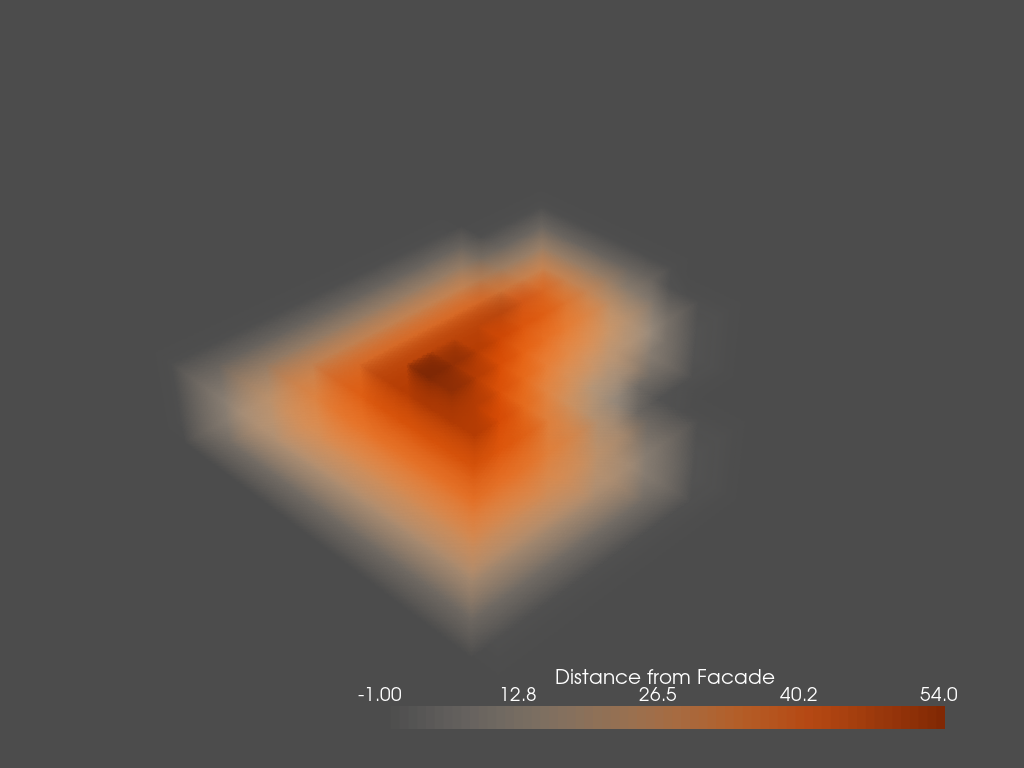

[(269.2590662461598, 192.75906624615982, 255.75906624615982),
 (31.5, -45.0, 18.0),
 (0.0, 0.0, 1.0)]

In [15]:
# initiating the plotter
p = pv.Plotter()

l = envelope_eu_dist_lattice

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Distance from Facade"] = l.flatten(order="F")  # Flatten the Lattice

# adding the volume
p.add_volume(grid, cmap="Oranges", shade=False, show_scalar_bar=True)

# plotting
p.show()

csv_path = os.path.relpath('../Data/dynamic output/dist_fac.csv')
envelope_eu_dist_lattice.to_csv(csv_path)

### Credits

In [16]:
__author__ = "Shervin Azadi and Pirouz Nourian"
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Spatial Computing Design Studio Workshop on Solar Envelope"